<a href="https://colab.research.google.com/github/yuchunsunshine/PINN/blob/main/PINN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [8]:
import matplotlib.animation as animation

In [23]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)


def initial_condition(x, y):
    return torch.sin(2 * torch.pi * x) * torch.sin(2 * torch.pi * y)


def generate_training_data(num_points):
    x = torch.rand(num_points, 1, requires_grad = True)
    y = torch.rand(num_points, 1, requires_grad = True)
    t = torch.rand(num_points, 1, requires_grad = True)
    # generates a tensor of shape (num_points, 1) with random values uniformly distributed in the range [0, 1).
    # The requires_grad=True argument indicates that gradients should be computed with respect to this tensor during backpropagation

    return x, y, t


def boundary_condition(x, custom_value):
    return torch.full_like(x, custom_value, requires_grad = True)
    # torch.full_like(x, custom_value) creates a new tensor filled with custom_value that has the same shape and type as x.


def generate_boundary_points(num_points):
    x_boundary = torch.rand(num_points, requires_grad = True)
    y_boundary = torch.rand(num_points, requires_grad = True)
    # This line creates a tensor y_boundary containing num_points random values uniformly distributed in the range [0, 1).
    # torch.rand generates random numbers between 0 and 1.

    return x_boundary.view(-1, 1), y_boundary.view(-1, 1)


def generate_boundary_training_data(num_points):
    x_boundary, y_boundary = generate_boundary_points(num_points)
    t = torch.rand(num_points, 1, requires_grad = True)
    # generates a tensor t of shape (num_points, 1) with random values uniformly distributed in the range [0, 1).

    return x_boundary, y_boundary, t


def pde(x, y, t, model):
    input_data = torch.cat([x, y, t], dim = 1)
    # This line concatenates the tensors x, y, and t along dimension 1 to create a single tensor input_data.
    u = model(input_data)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True, retain_graph=True)[0]
    u_f = ((8* torch.pi **2) -1) * torch.exp ( - t ) * torch.sin (2*  torch.pi * x ) * torch.sin (2*  torch.pi * y )
    heat_eq_residual = u_t - u_xx - u_yy -  u_f

    return heat_eq_residual


def train_PINN(model, num_iterations, num_points):
    optimizer = optim.Adam(model.parameters(), lr = 1e-3)
    loss_history = []

    for iteration in range(num_iterations):
        optimizer.zero_grad()
        # This line sets the gradients of all model parameters to zero.
        # This is necessary before performing the backpropagation because by default, gradients are accumulated in PyTorch.

        # generate training data
        x, y, t = generate_training_data(num_points)

        # boundary training data
        x_b, y_b, t_b = generate_boundary_training_data(num_points)

        # initial training data
        x_i, y_i, _ = generate_training_data(num_points)
        t_i = torch.zeros_like(t)
        u_i = initial_condition(x_i, y_i)


        x_b_1 = boundary_condition(x_b, 0.0)
        y_b_2 = boundary_condition(y_b, 1.0)
        u0 = boundary_condition(y_b, 0.0)


        u_b_x = boundary_condition(x_b, 1.0)
        u_b_y = boundary_condition(y_b, 0.0)

        u_pred_ux = model(torch.cat([u_b_x, y_b, t_b], dim = 1))
        u_pred_uy = model(torch.cat([x_b, u_b_y, t_b], dim = 1))

        u_x = torch.autograd.grad(u_pred_ux, u_b_x, grad_outputs=torch.ones_like(u_pred_ux), create_graph=True, retain_graph=True)[0]
        u_y = torch.autograd.grad(u_pred_uy, u_b_y, grad_outputs=torch.ones_like(u_pred_uy), create_graph=True, retain_graph=True)[0]

        u_x_0 = 2 * torch.pi * torch.exp(- t_b) * torch.sin(2 * torch.pi * y_b)
        u_y_0 = 2 * torch.pi * torch.exp(- t_b) * torch.sin(2 * torch.pi * x_b)


        residual = pde(x, y, t, model)

        loss = nn.MSELoss()(u_i, model(torch.cat([x_i, y_i, t_i], dim = 1))) + \
               nn.MSELoss()(residual, torch.zeros_like(residual)) + \
               nn.MSELoss()(u0, model(torch.cat([x_b_1, y_b, t_b], dim = 1))) + \
               nn.MSELoss()(u0, model(torch.cat([x_b, y_b_2, t_b], dim = 1))) + \
               nn.MSELoss()(u_x_0, u_x) + \
               nn.MSELoss()(u_y_0, u_y)

        loss.backward()
        # performs backpropagation, computing the gradients of the loss with respect to the model parameters.
        optimizer.step()
        # updates the model parameters using the gradients computed in the backpropagation step, based on the optimizer's update rule.

        loss_history.append(loss.item())

        if iteration % 100 == 0:
            print("iteration", iteration, "loss", loss)


    plt.plot(range(num_iterations), loss_history)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss vs Iteration')
    plt.show()


iteration 0 loss tensor(688.0159, grad_fn=<AddBackward0>)
iteration 100 loss tensor(617.2158, grad_fn=<AddBackward0>)
iteration 200 loss tensor(99.0747, grad_fn=<AddBackward0>)
iteration 300 loss tensor(27.4085, grad_fn=<AddBackward0>)
iteration 400 loss tensor(11.2420, grad_fn=<AddBackward0>)
iteration 500 loss tensor(3.8891, grad_fn=<AddBackward0>)
iteration 600 loss tensor(3.0749, grad_fn=<AddBackward0>)
iteration 700 loss tensor(2.7172, grad_fn=<AddBackward0>)
iteration 800 loss tensor(1.8724, grad_fn=<AddBackward0>)
iteration 900 loss tensor(1.6493, grad_fn=<AddBackward0>)
iteration 1000 loss tensor(1.2758, grad_fn=<AddBackward0>)
iteration 1100 loss tensor(1.3117, grad_fn=<AddBackward0>)
iteration 1200 loss tensor(1.4523, grad_fn=<AddBackward0>)
iteration 1300 loss tensor(1.3788, grad_fn=<AddBackward0>)
iteration 1400 loss tensor(0.9337, grad_fn=<AddBackward0>)
iteration 1500 loss tensor(0.9346, grad_fn=<AddBackward0>)
iteration 1600 loss tensor(1.2183, grad_fn=<AddBackward0>)
it

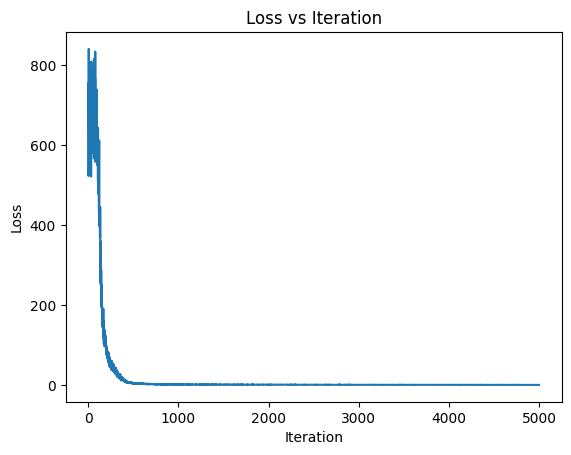

In [33]:
model = PINN()
num_iterations = 5000
num_points = 200
train_PINN(model, num_iterations, num_points)

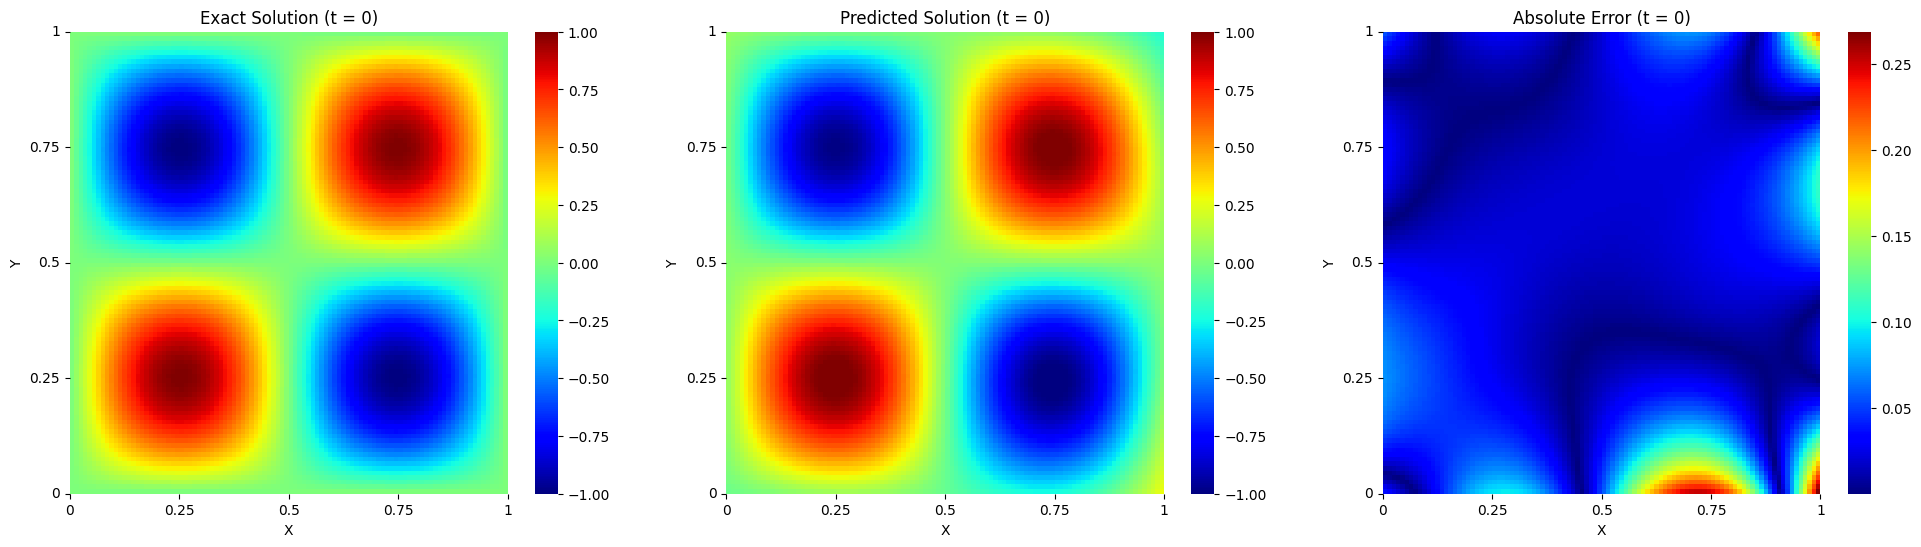

In [34]:
with torch.no_grad():
    # torch.no_grad() is a context manager that disables gradient calculation.
    # This is useful for inference, as it reduces memory usage and speeds up computations since gradients are not required.
    x_vals = torch.linspace(0, 1, 100)
    y_vals = torch.linspace(0, 1, 100)
    X, Y = torch.meshgrid(x_vals, y_vals)
    t_val = torch.ones_like(X) * 0

    input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim = 1)
    # X.flatten(), Y.flatten(), and t_val.flatten() convert the 2D tensors into 1D tensors (vectors).
    # torch.stack([...], dim=1) stacks these vectors along the columns (dimension 1), r
    # esulting in a 2D tensor input_data with shape (10000, 3), where each row is a triplet (𝑥𝑖,𝑦𝑖,𝑡𝑖)
    predicted_solution = model(input_data).reshape(X.shape, Y.shape)

    exact_solution = torch.exp ( - t_val ) * torch.sin (2*  torch.pi * X ) * torch.sin (2*  torch.pi * Y )

    # Convert the tensor to a NumPy array for plotting
    exact_solution_np = exact_solution.numpy()

    plt.figure(figsize=(24, 6))

    x_ticks = [0, 25, 50, 75, 100]  # For 0 to 1 in a 100-point grid
    x_labels = ['0', '0.25', '0.5', '0.75', '1']
    y_ticks = [0, 25, 50, 75, 100]  # For 0 to 1 in a 100-point grid
    y_labels = ['0', '0.25', '0.5', '0.75', '1']

    # Plot the exact solution
    plt.subplot(1, 3, 1)
    sns.heatmap(exact_solution, cmap="jet", vmax = 1, vmin = -1)
    plt.title("Exact Solution (t = 0)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().invert_yaxis()  # Invert the y-axis to place the origin at the bottom-left corner
    plt.xticks(x_ticks, x_labels, rotation=0)
    plt.yticks(y_ticks, y_labels, rotation=0)

    # Plot the predicted solution
    plt.subplot(1, 3, 2)
    sns.heatmap(predicted_solution, cmap="jet", vmax = 1, vmin = -1)
    plt.title("Predicted Solution (t = 0)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().invert_yaxis()  # Invert the y-axis to place the origin at the bottom-left corner
    plt.xticks(x_ticks, x_labels, rotation=0)
    plt.yticks(y_ticks, y_labels, rotation=0)

    # Plot the error
    plt.subplot(1, 3, 3)
    sns.heatmap(abs(predicted_solution - exact_solution), cmap="jet")
    plt.title("Absolute Error (t = 0)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().invert_yaxis()  # Invert the y-axis to place the origin at the bottom-left corner
    plt.xticks(x_ticks, x_labels, rotation=0)
    plt.yticks(y_ticks, y_labels, rotation=0)

    plt.show()

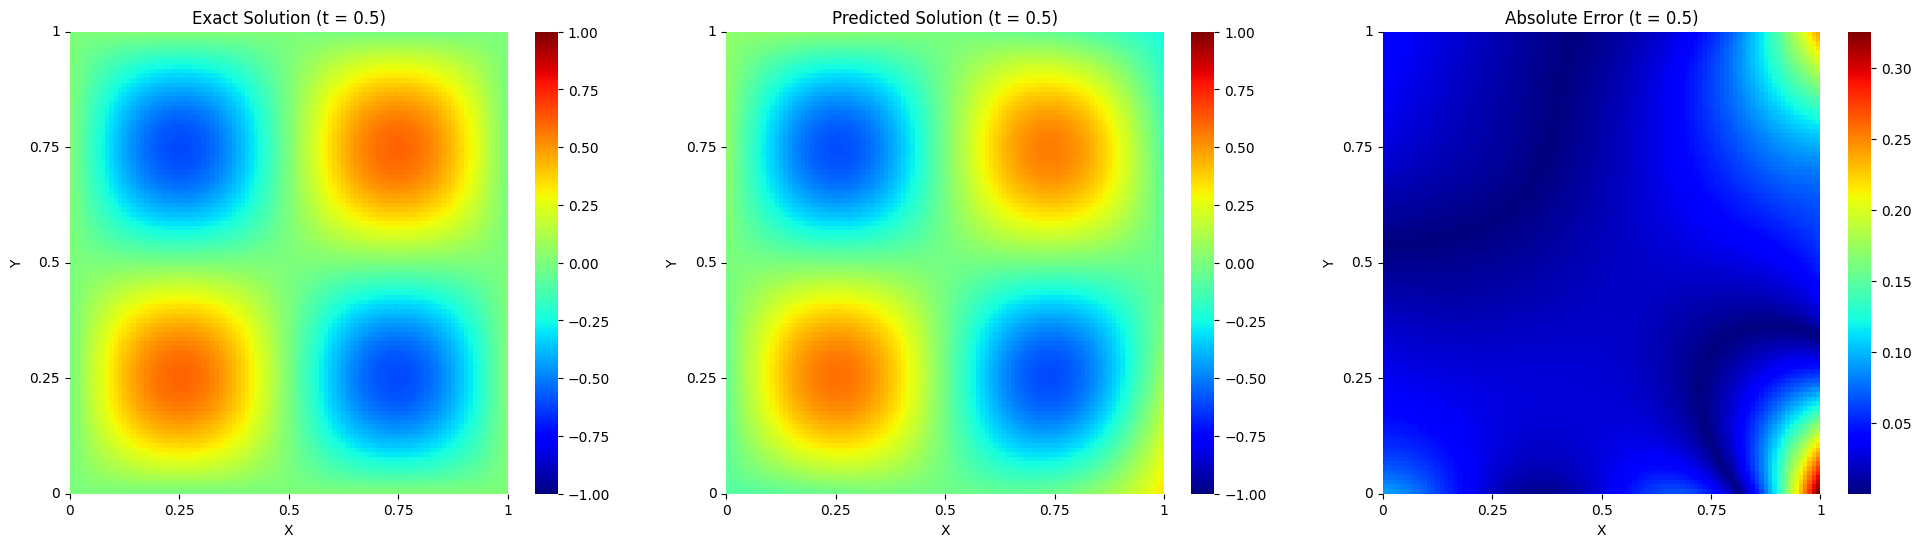

In [36]:
with torch.no_grad():
    # torch.no_grad() is a context manager that disables gradient calculation.
    # This is useful for inference, as it reduces memory usage and speeds up computations since gradients are not required.
    x_vals = torch.linspace(0, 1, 100)
    y_vals = torch.linspace(0, 1, 100)
    X, Y = torch.meshgrid(x_vals, y_vals)
    t_val = torch.ones_like(X) * 0.5

    input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim = 1)
    # X.flatten(), Y.flatten(), and t_val.flatten() convert the 2D tensors into 1D tensors (vectors).
    # torch.stack([...], dim=1) stacks these vectors along the columns (dimension 1), r
    # esulting in a 2D tensor input_data with shape (10000, 3), where each row is a triplet (𝑥𝑖,𝑦𝑖,𝑡𝑖)
    predicted_solution = model(input_data).reshape(X.shape, Y.shape)

    exact_solution = torch.exp ( - t_val ) * torch.sin (2*  torch.pi * X ) * torch.sin (2*  torch.pi * Y )

    # Convert the tensor to a NumPy array for plotting
    exact_solution_np = exact_solution.numpy()

    plt.figure(figsize=(24, 6))

    x_ticks = [0, 25, 50, 75, 100]  # For 0 to 1 in a 100-point grid
    x_labels = ['0', '0.25', '0.5', '0.75', '1']
    y_ticks = [0, 25, 50, 75, 100]  # For 0 to 1 in a 100-point grid
    y_labels = ['0', '0.25', '0.5', '0.75', '1']

    # Plot the exact solution
    plt.subplot(1, 3, 1)
    sns.heatmap(exact_solution, cmap="jet", vmax = 1, vmin = -1)
    plt.title("Exact Solution (t = 0.5)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().invert_yaxis()  # Invert the y-axis to place the origin at the bottom-left corner
    plt.xticks(x_ticks, x_labels, rotation=0)
    plt.yticks(y_ticks, y_labels, rotation=0)

    # Plot the predicted solution
    plt.subplot(1, 3, 2)
    sns.heatmap(predicted_solution, cmap="jet", vmax = 1, vmin = -1)
    plt.title("Predicted Solution (t = 0.5)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().invert_yaxis()  # Invert the y-axis to place the origin at the bottom-left corner
    plt.xticks(x_ticks, x_labels, rotation=0)
    plt.yticks(y_ticks, y_labels, rotation=0)

    # Plot the error
    plt.subplot(1, 3, 3)
    sns.heatmap(abs(predicted_solution - exact_solution), cmap="jet")
    plt.title("Absolute Error (t = 0.5)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().invert_yaxis()  # Invert the y-axis to place the origin at the bottom-left corner
    plt.xticks(x_ticks, x_labels, rotation=0)
    plt.yticks(y_ticks, y_labels, rotation=0)

    plt.show()

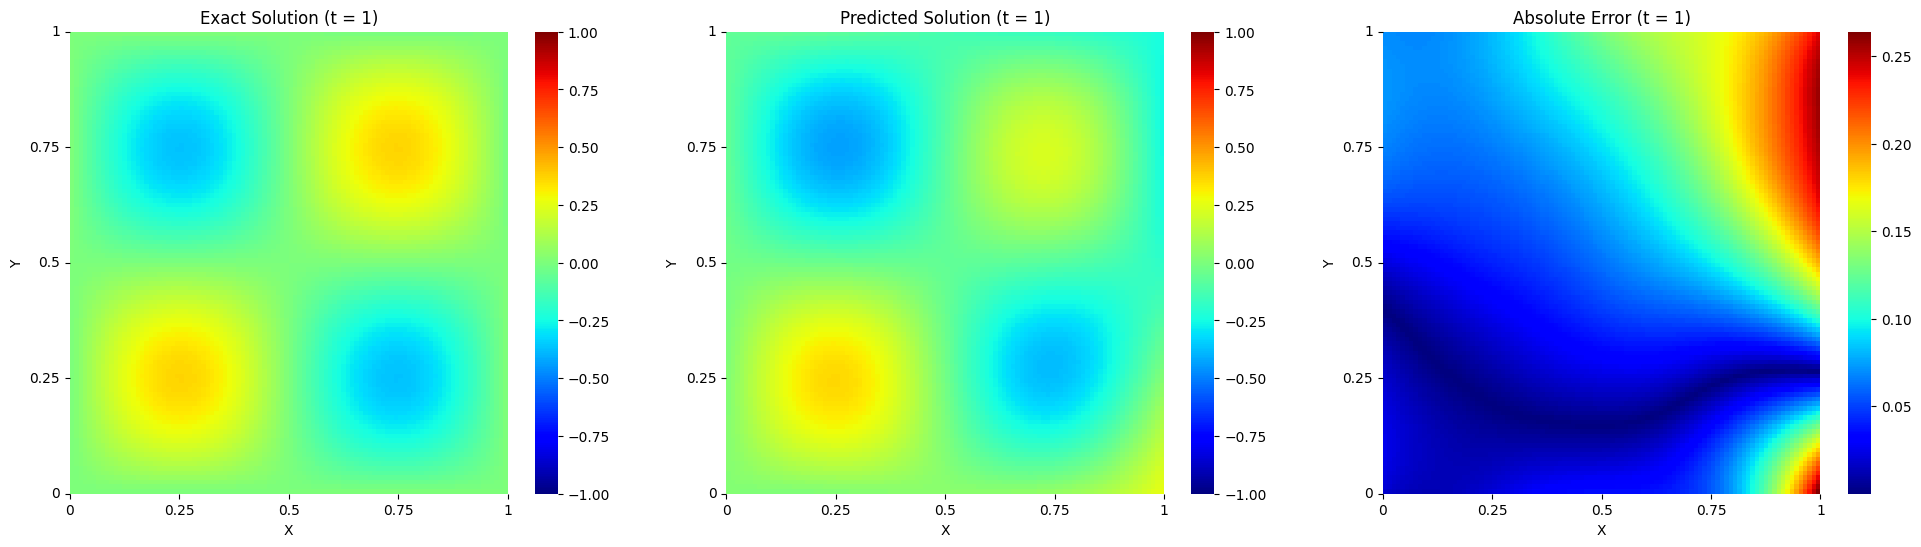

In [35]:
with torch.no_grad():
    # torch.no_grad() is a context manager that disables gradient calculation.
    # This is useful for inference, as it reduces memory usage and speeds up computations since gradients are not required.
    x_vals = torch.linspace(0, 1, 100)
    y_vals = torch.linspace(0, 1, 100)
    X, Y = torch.meshgrid(x_vals, y_vals)
    t_val = torch.ones_like(X) * 1

    input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim = 1)
    # X.flatten(), Y.flatten(), and t_val.flatten() convert the 2D tensors into 1D tensors (vectors).
    # torch.stack([...], dim=1) stacks these vectors along the columns (dimension 1), r
    # esulting in a 2D tensor input_data with shape (10000, 3), where each row is a triplet (𝑥𝑖,𝑦𝑖,𝑡𝑖)
    predicted_solution = model(input_data).reshape(X.shape, Y.shape)

    exact_solution = torch.exp ( - t_val ) * torch.sin (2*  torch.pi * X ) * torch.sin (2*  torch.pi * Y )

    # Convert the tensor to a NumPy array for plotting
    exact_solution_np = exact_solution.numpy()

    plt.figure(figsize=(24, 6))

    x_ticks = [0, 25, 50, 75, 100]  # For 0 to 1 in a 100-point grid
    x_labels = ['0', '0.25', '0.5', '0.75', '1']
    y_ticks = [0, 25, 50, 75, 100]  # For 0 to 1 in a 100-point grid
    y_labels = ['0', '0.25', '0.5', '0.75', '1']

    # Plot the exact solution
    plt.subplot(1, 3, 1)
    sns.heatmap(exact_solution, cmap="jet", vmax = 1, vmin = -1)
    plt.title("Exact Solution (t = 1)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().invert_yaxis()  # Invert the y-axis to place the origin at the bottom-left corner
    plt.xticks(x_ticks, x_labels, rotation=0)
    plt.yticks(y_ticks, y_labels, rotation=0)

    # Plot the predicted solution
    plt.subplot(1, 3, 2)
    sns.heatmap(predicted_solution, cmap="jet", vmax = 1, vmin = -1)
    plt.title("Predicted Solution (t = 1)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().invert_yaxis()  # Invert the y-axis to place the origin at the bottom-left corner
    plt.xticks(x_ticks, x_labels, rotation=0)
    plt.yticks(y_ticks, y_labels, rotation=0)

    # Plot the error
    plt.subplot(1, 3, 3)
    sns.heatmap(abs(predicted_solution - exact_solution), cmap="jet")
    plt.title("Absolute Error (t = 1)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().invert_yaxis()  # Invert the y-axis to place the origin at the bottom-left corner
    plt.xticks(x_ticks, x_labels, rotation=0)
    plt.yticks(y_ticks, y_labels, rotation=0)

    plt.show()